In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim

from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF

import PIL
from PIL import Image

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**DATASET**

In [25]:
TRAIN_IMAGES_PATH = 'Crack_Segmentation_Dataset/images'
TRAIN_MASKS_PATH = 'Crack_Segmentation_Dataset/masks'
TEST_PATH= 'Data/all/test'

In [26]:
#Checking folders
images_files=os.listdir(TRAIN_IMAGES_PATH)
masks_files=os.listdir(TRAIN_MASKS_PATH)
for i in images_files:
    if i not in masks_files:
        os.remove(os.path.join(TRAIN_IMAGES_PATH, i))
for i in masks_files:
    if i not in images_files:
        os.remove(os.path.join(TRAIN_MASKS_PATH, i))  

In [27]:
# creating our own Dataset
class CrackDataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            #mask_max = mask.max().item()
            #mask /= mask_max
        else:
            return img
        
        return img, mask    

In [28]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_data_target = T.Compose([
                T.Resize([224, 224]),
                #T.Grayscale(1),
                T.ToTensor(),
                T.Lambda(lambda x: torch.where(x > 0.5, torch.tensor([1.0]), torch.tensor([0.0])))
                ])

In [29]:
full_dataset = CrackDataset(TRAIN_IMAGES_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_target)

In [30]:
BATCH_SIZE = 8
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

9027 2257


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


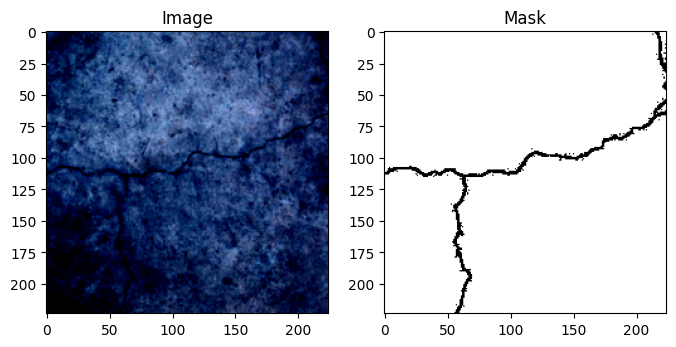

In [31]:
#Check image and mask
id = 25
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(train_dataset[id][0].permute(1, 2, 0));ax[0].set_title("Image")
ax[1].imshow(train_dataset[id][1][0],'binary');ax[1].set_title("Mask")
plt.show()

**Dataloader**

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


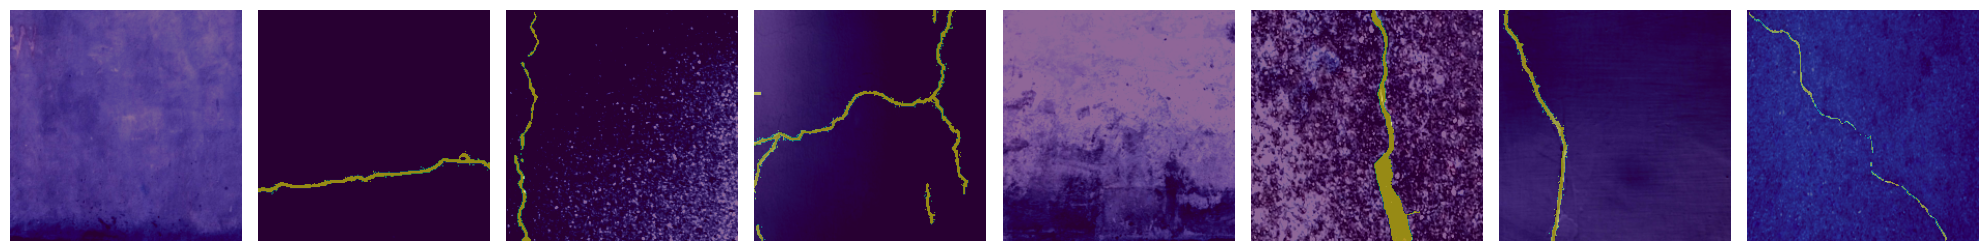

In [34]:
imgs, masks = next(iter(train_loader))
#print(masks)
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

**Model**

**Creating model**

In [35]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', num_classes=2, pretrained=False)
model.to(device)
print(model)

Using cache found in C:\Users\Zetans/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [36]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


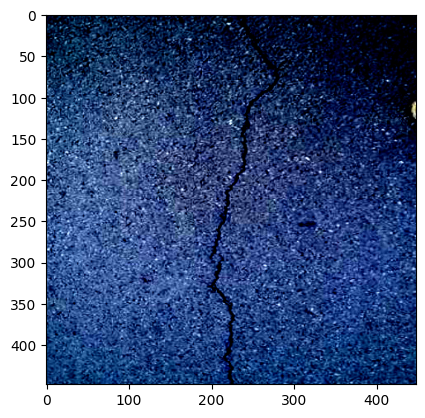

In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
img = Image.open("CFD_001.jpg")
img = preprocess_input(np.array(img))
img = img.permute(2, 1, 0)
plt.imshow(img)

**Training**

In [38]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [39]:
def train(model, optimiser, epochs = 100, store_every = 1):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1) 
            #print(y)           
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')

In [40]:
'''
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.1, momentum=0.95,
                                 weight_decay=1e-4)
train(model, optimiser_unet, epochs)'''

'\nepochs = 5\noptimiser_unet = torch.optim.SGD(model.parameters(),\n                                 lr=0.1, momentum=0.95,\n                                 weight_decay=1e-4)\ntrain(model, optimiser_unet, epochs)'

In [41]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
val_losses = []
train_losses = []

train_accs = []
val_accs = []


In [42]:
def train(dataloader, model, loss_function, optimizer, epoch):
    train_correct_num, train_total, train_cost_acum = 0, 0, 0.0
    size = len(dataloader.dataset)
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long).squeeze(1)
        #print(x.shape)
        scores = model(x)["out"]
        cost = loss_function(input=scores, target=y)
        #cost.requires_grad = True


        #Backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        train_predictions = torch.argmax(scores, dim=1)
        train_correct_num += (train_predictions == y).sum()
        train_total += torch.numel(train_predictions)#total numero de elementos de train_predictions, if size=[a,b,c ] returns a*b*c
        train_cost_acum += cost
        
        if batch % 9 == 1:
            train_acc = float(train_correct_num)/train_total#el train total ya considera el batch
            train_cost_every = float(train_cost_acum)/batch#Se divide entre el batch, xq por cada batch se aumenta el loss
            writer.add_scalar('training loss',
                            train_cost_every,
                            epoch * len(dataloader) + batch)
            writer.add_scalar('training accuracy',
                            train_acc,
                            epoch * len(dataloader) + batch)
            print("loss: ", train_cost_every, "Accuracy: ", train_acc)
            train_losses.append(train_cost_every)
            train_accs.append(train_acc)

In [43]:
def test(dataloader, model, loss_function,t):
    num_batches = len(dataloader)
    model.eval()
    test_loss, train_correct_num, train_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            pred = model(x)["out"]
            loss = loss_function(input=pred, target=y)
            
            test_loss += loss.item()
            train_predictions = torch.argmax(pred, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)

    test_loss /= num_batches
    train_correct_num = train_correct_num/train_total
    writer.add_scalar('validation loss',
                    test_loss,t)
    writer.add_scalar('validation accuracy',
                    train_correct_num,t)
    print(f"Test Error: \n Accuracy: {(100*train_correct_num):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    val_losses.append(test_loss)
    val_accs.append(train_correct_num)

In [44]:
loss_fn = torch.nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, t)
    test(val_loader, model, loss_fn, t)
writer.close()

Epoch 1
-------------------------------
loss:  1.3776984214782715 Accuracy:  0.5216886559311225
loss:  0.313547420501709 Accuracy:  0.8826775205820965
loss:  0.25487262324283 Accuracy:  0.9167567661830357
loss:  0.2283802032470703 Accuracy:  0.9312668544653853
loss:  0.20618353663264094 Accuracy:  0.939791604604424
loss:  0.19116001543791397 Accuracy:  0.9443107071618541
loss:  0.18028255809437144 Accuracy:  0.9478865198074208
loss:  0.1714724451303482 Accuracy:  0.9501342581804356
loss:  0.16379579779219955 Accuracy:  0.9526662432023063
loss:  0.16080835388927925 Accuracy:  0.9542117169250983
loss:  0.15664476876730446 Accuracy:  0.9555354283357365
loss:  0.155003080368042 Accuracy:  0.956555128916511
loss:  0.1529134347898151 Accuracy:  0.9573957397234462
loss:  0.15101502305370265 Accuracy:  0.9580135067419825
loss:  0.1483419673649345 Accuracy:  0.9587852711580238
loss:  0.1446377529817469 Accuracy:  0.9597028678031432
loss:  0.14178351040544182 Accuracy:  0.9603681513674606
loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

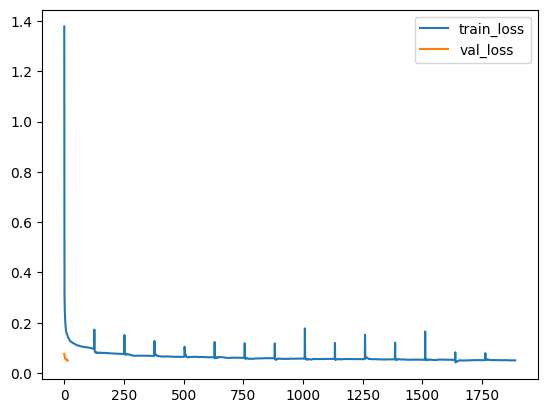

In [47]:
from matplotlib import pyplot as plt
plt.plot([los for los in train_losses], label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

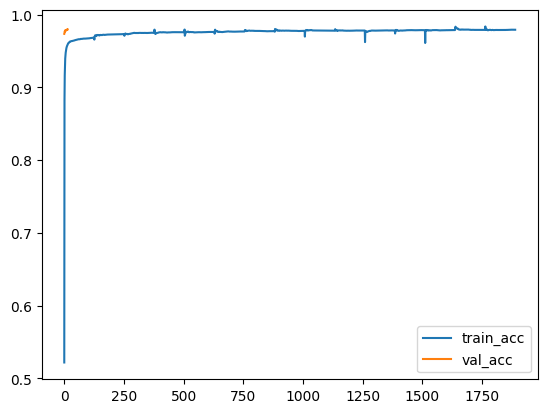

In [48]:
plt.plot(train_accs, label='train_acc')
plt.plot([ac.data.cpu() for ac in val_accs], label='val_acc')
plt.legend()
plt.show

In [49]:
torch.save(model.state_dict(), "deepLabv3_With_TF_resnet50_10kImages_97_Dict.pth")
torch.save(model, "deepLabv3_With_TF_resnet50_4kImages_97_DictComplete.pth")

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)["out"]
    print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
import segmentation_models_pytorch as smp
import torch
# Cargar el modelo entrenado
model_read = smp.Unet(encoder_name="resnet34", encoder_weights=None, classes=2, activation='softmax')
model_read.load_state_dict(torch.load('unet_Without_TF_resnet34_4kImages_97_Dict.pth'))

# Establecer el modelo en modo de evaluación
model_read.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = model_read.to(device)
with torch.no_grad():
    scores = model_read(imgs_val)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))